In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Full data

In [2]:
df = pd.read_json("results/task1/task1_data.json", lines=True)
#replace llama3.2 in the model column with llama3b
df['model'] = df['model'].replace('llama3.2', 'llama3b').replace('llama3.3', 'llama70b')
#replace llama3.2 in the model column with llama3b

#replace llama3.2 in the model column with llama3b
df['prompt'] = df['prompt'].replace('no', 'benchmark').replace('prompt1', 'persona')

df.drop(columns=['all_fit'], inplace=True)

df.rename(
    columns={
        'c_all_fit_hits': 'correct_match',
        'r_all_fit_hits': 'related_match',
        'r_all_fit_recall': 'related_recall'
    },
    inplace=True
)

code_path = "datasets/occupation.xlsx"
zone_path = "datasets/job_zone.xlsx"
# Read the Excel file
occupation = pd.read_excel(code_path)
occupation.drop(columns=['Description'], inplace=True)
occupation.columns = ['code', 'title']

zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']

# Merge the occupation data with the main dataframe
df = df.merge(occupation, left_on='title', right_on='title', how='left')
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["industry"] = df["code"].apply(lambda x: x.split("-")[0])
df

,title,iteration,correct_match,related_match,related_recall,model,prompt,code,zone,industry
0,Chief Executives,0,1,1,0.5,deepseek-r1,benchmark,11-1011.00,5,11
1,Chief Sustainability Officers,0,1,1,0.1,deepseek-r1,benchmark,11-1011.03,5,11
2,General and Operations Managers,0,0,0,0.0,deepseek-r1,benchmark,11-1021.00,4,11
3,Legislators,0,0,0,0.0,deepseek-r1,benchmark,11-1031.00,4,11
4,Advertising and Promotions Managers,0,0,1,0.9,deepseek-r1,benchmark,11-2011.00,4,11
...,...,...,...,...,...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,9,0,1,0.2,mistral,persona,53-7071.00,2,53
73836,"Pump Operators, Except Wellhead Pumpers",9,0,0,0.0,mistral,persona,53-7072.00,2,53
73837,Wellhead Pumpers,9,0,0,0.0,mistral,persona,53-7073.00,2,53
73838,Refuse and Recyclable Material Collectors,9,0,0,0.0,mistral,persona,53-7081.00,2,53


Averaged match rate

In [3]:
df_avg = df.groupby(["title", "model", "prompt", "code", "zone", "industry"]).mean().reset_index().drop(columns=["iteration"])
df_avg

,title,model,prompt,code,zone,industry,correct_match,related_match,related_recall
0,Accountants and Auditors,deepseek-r1,benchmark,13-2011.00,4,13,0.0,0.0,0.00
1,Accountants and Auditors,deepseek-r1,persona,13-2011.00,4,13,0.0,1.0,0.59
2,Accountants and Auditors,llama3b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
3,Accountants and Auditors,llama3b,persona,13-2011.00,4,13,0.0,1.0,0.60
4,Accountants and Auditors,llama70b,benchmark,13-2011.00,4,13,0.0,1.0,0.56
...,...,...,...,...,...,...,...,...,...
7379,Zoologists and Wildlife Biologists,llama3b,persona,19-1023.00,4,19,0.0,1.0,0.40
7380,Zoologists and Wildlife Biologists,llama70b,benchmark,19-1023.00,4,19,0.0,1.0,0.33
7381,Zoologists and Wildlife Biologists,llama70b,persona,19-1023.00,4,19,0.0,1.0,0.39
7382,Zoologists and Wildlife Biologists,mistral,benchmark,19-1023.00,4,19,0.0,0.0,0.00


Correct Match Pivot

In [4]:
df_pivot = df.pivot_table(index=["title", "industry", "zone", "model", "iteration"], columns=["prompt"], values="correct_match").reset_index()
df_pivot["difference"] = df_pivot["persona"] - df_pivot["benchmark"]
df_related_hit_pivot = df.pivot_table(index=["title", "industry", "zone", "model", "iteration"], columns=["prompt"], values="related_match").reset_index()
df_related_hit_pivot["difference"] = df_related_hit_pivot["persona"] - df_related_hit_pivot["benchmark"]
df_recall_pivot = df.pivot_table(index=["title", "industry", "zone", "model", "iteration"], columns=["prompt"], values="related_recall").reset_index()
df_recall_pivot["difference"] = df_recall_pivot["persona"] - df_recall_pivot["benchmark"]
df_pivot

prompt,title,industry,zone,model,iteration,benchmark,persona,difference
0,Accountants and Auditors,13,4,deepseek-r1,0,0.0,0.0,0.0
1,Accountants and Auditors,13,4,deepseek-r1,1,0.0,0.0,0.0
2,Accountants and Auditors,13,4,deepseek-r1,2,0.0,0.0,0.0
3,Accountants and Auditors,13,4,deepseek-r1,3,0.0,0.0,0.0
4,Accountants and Auditors,13,4,deepseek-r1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
36915,Zoologists and Wildlife Biologists,19,4,mistral,5,0.0,0.0,0.0
36916,Zoologists and Wildlife Biologists,19,4,mistral,6,0.0,0.0,0.0
36917,Zoologists and Wildlife Biologists,19,4,mistral,7,0.0,0.0,0.0
36918,Zoologists and Wildlife Biologists,19,4,mistral,8,0.0,0.0,0.0


In [5]:
deepseek = df_avg[df_avg["model"] == "deepseek-r1"]
llama3b = df_avg[df_avg["model"] == "llama3b"]
llama70b = df_avg[df_avg["model"] == "llama70b"]
mistral = df_avg[df_avg["model"] == "mistral"]

### Descriptive Stats

### Correct Match

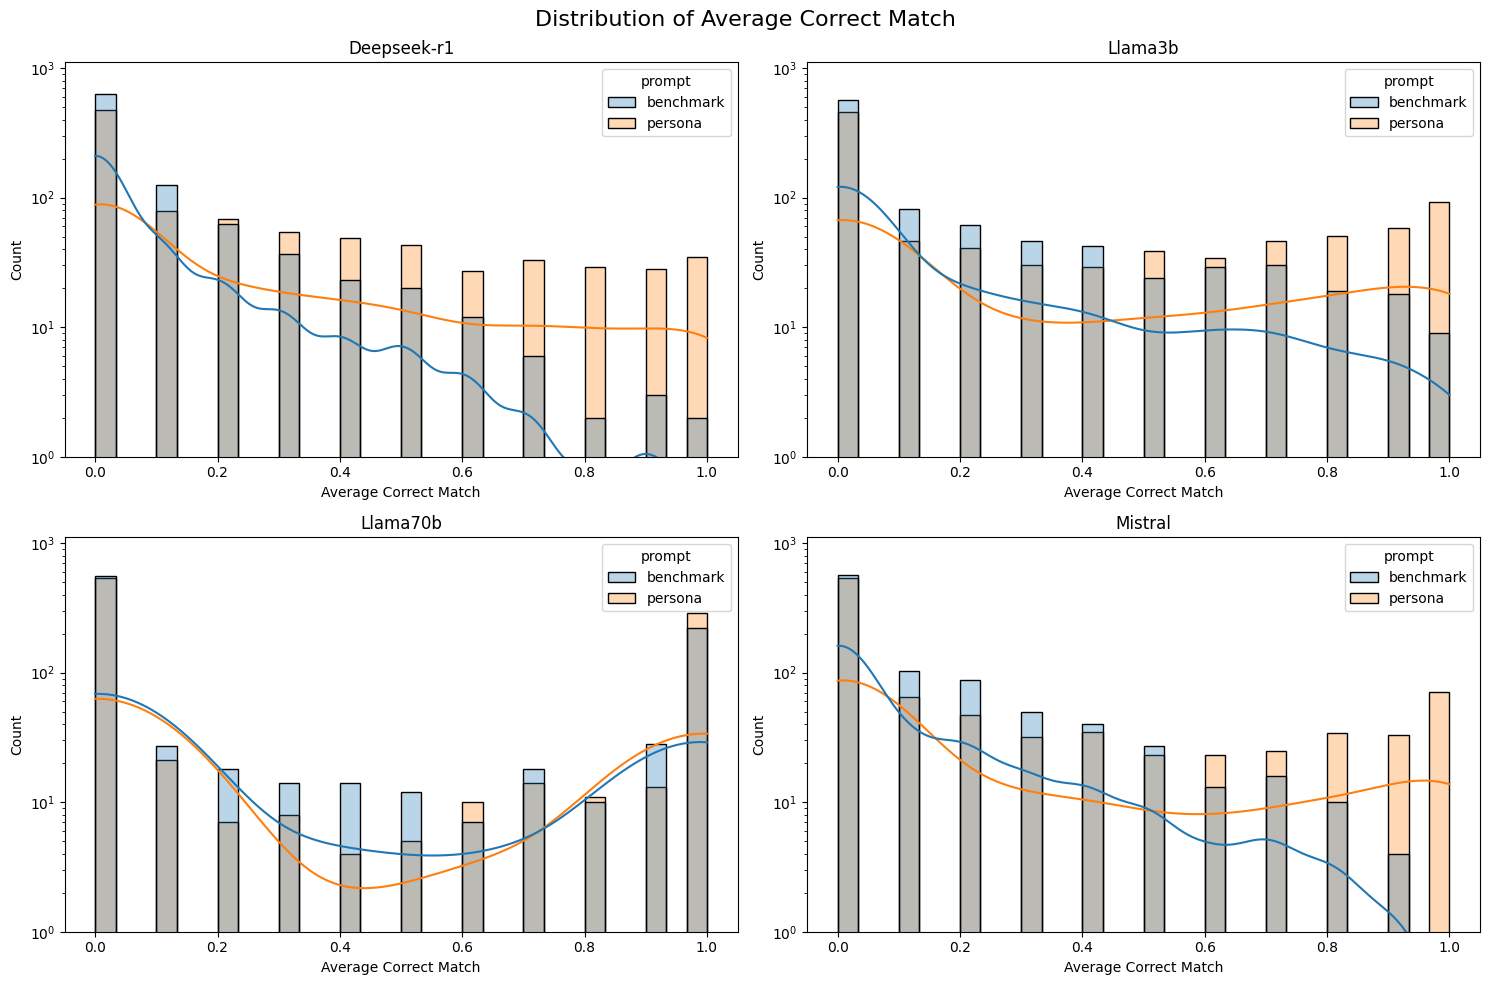

In [6]:
plt.figure(figsize=(15, 10))

# Calculate the maximum y-value across all plots
max_y = max(
    deepseek["correct_match"].value_counts().max(),
    llama3b["correct_match"].value_counts().max(),
    llama70b["correct_match"].value_counts().max(),
    mistral["correct_match"].value_counts().max()
)
#add a title to the plot
plt.suptitle("Distribution of Average Correct Match", fontsize=16)
# Plot the distribution of the data
plt.subplot(2, 2, 1)
sns.histplot(data=deepseek, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Deepseek-r1")

plt.subplot(2, 2, 2)
sns.histplot(data=llama3b, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama3b")

plt.subplot(2, 2, 3)
sns.histplot(data=llama70b, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Llama70b")

plt.subplot(2, 2, 4)
sns.histplot(data=mistral, x="correct_match", hue="prompt", bins=30, kde=True, alpha=0.3)
plt.xlabel("Average Correct Match")
plt.yscale('log')
plt.ylim(1, max_y)  # Set the same y-axis limit
plt.title("Mistral")

plt.tight_layout()
plt.show()

more occupations get a higher correct match rate using persona than benchmark. For llama70b, more occupations get a 100% correct match than benchmark.

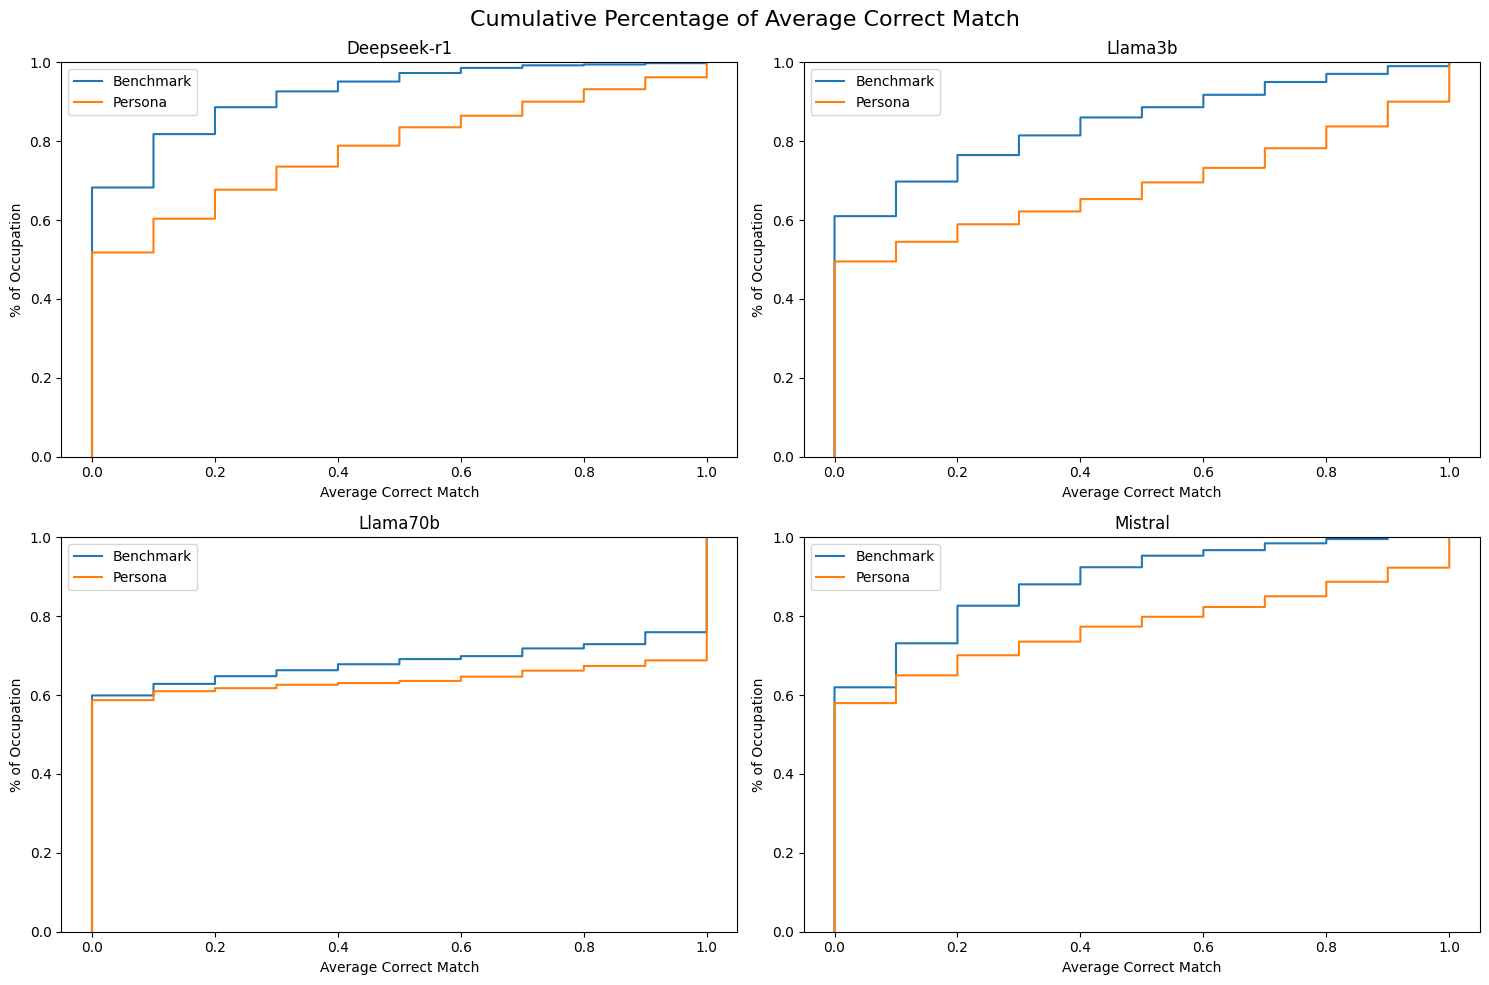

In [7]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]
plt.figure(figsize=(15, 10))
plt.suptitle("Cumulative Percentage of Average Correct Match", fontsize=16)
for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    for prompt in ["benchmark", "persona"]:
        data_subset = df_avg[(df_avg["model"] == model) & (df_avg["prompt"] == prompt)]
        sns.ecdfplot(data=data_subset, x="correct_match", label=prompt.capitalize(), )
    plt.title(f"{model.capitalize()}")
    plt.xlabel("Average Correct Match")
    plt.ylabel("% of Occupation")
    plt.legend()

plt.tight_layout()
plt.show()

looking at Average correct match = 0, at least half of the occupation do not get a match in all 10 rounds. However, persona prompt helped more occupation to get more matches.

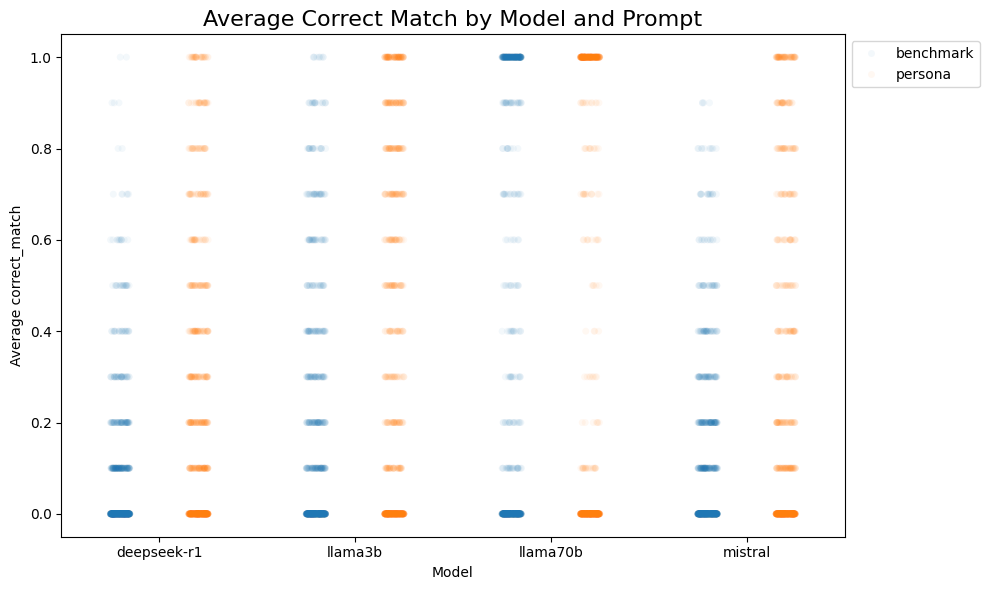

In [8]:
# Calculate the average correct_match for each model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(10, 6))
# sns.violinplot(data=df_avg, x="model", y="correct_match", hue="prompt", bw_adjust=3)
sns.stripplot(data=df_avg, x="model", y="correct_match", hue="prompt", dodge=True, 
              size=5, alpha=0.05, jitter=True)

# Add labels and title
plt.title("Average Correct Match by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average correct_match")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

for model in models:
    # Filter the dataframe for the current model
    model_data = df_pivot[df_pivot['model'] == model].copy()
    model_data = model_data.groupby(["title", "model", "industry", "zone"]).mean().reset_index().drop(columns=["iteration"])
    model_data['difference'] = model_data['persona'] - model_data['benchmark']

    # Perform the Wilcoxon signed-rank test on the differences
    statistic, p_value = stats.wilcoxon(model_data['persona'], model_data["benchmark"], alternative='greater')
    # Print the results

    print(f"Model: {model}")
    print("Wilcoxon Signed-Rank Test Results:")
    print(f"  W-statistic: {statistic:.4f}")
    print(f"  p-value: {p_value:.4f}")

    # Interpretation of the p-value
    alpha = 0.01  # significance level
    if p_value < alpha:
        print(f"\nThe p-value ({p_value:.4f}) is less than the significance level ({alpha}).")
        print("This suggests that there is a statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We reject the null hypothesis that there is no difference.")
    else:
        print(f"\nThe p-value ({p_value:.4f}) is greater than or equal to the significance level ({alpha}).")
        print("This suggests that there is no statistically significant difference in the similarity scores")
        print("between the benchmark and persona conditions across all occupations and iterations.")
        print("We fail to reject the null hypothesis.")
    print("\n" + "-" * 50 + "\n")


Model: deepseek-r1
Wilcoxon Signed-Rank Test Results:
  W-statistic: 80041.5000
  p-value: 0.0000

The p-value (0.0000) is less than the significance level (0.01).
This suggests that there is a statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We reject the null hypothesis that there is no difference.

--------------------------------------------------

Model: llama3b
Wilcoxon Signed-Rank Test Results:
  W-statistic: 90229.0000
  p-value: 0.0000

The p-value (0.0000) is less than the significance level (0.01).
This suggests that there is a statistically significant difference in the similarity scores
between the benchmark and persona conditions across all occupations and iterations.
We reject the null hypothesis that there is no difference.

--------------------------------------------------

Model: llama70b
Wilcoxon Signed-Rank Test Results:
  W-statistic: 13991.0000
  p-value: 0.0000

The 

Simple non parametric t-test (wilcoxon test) shows the average match rate of persona prompt differs from the benchmark and is statistically significant.

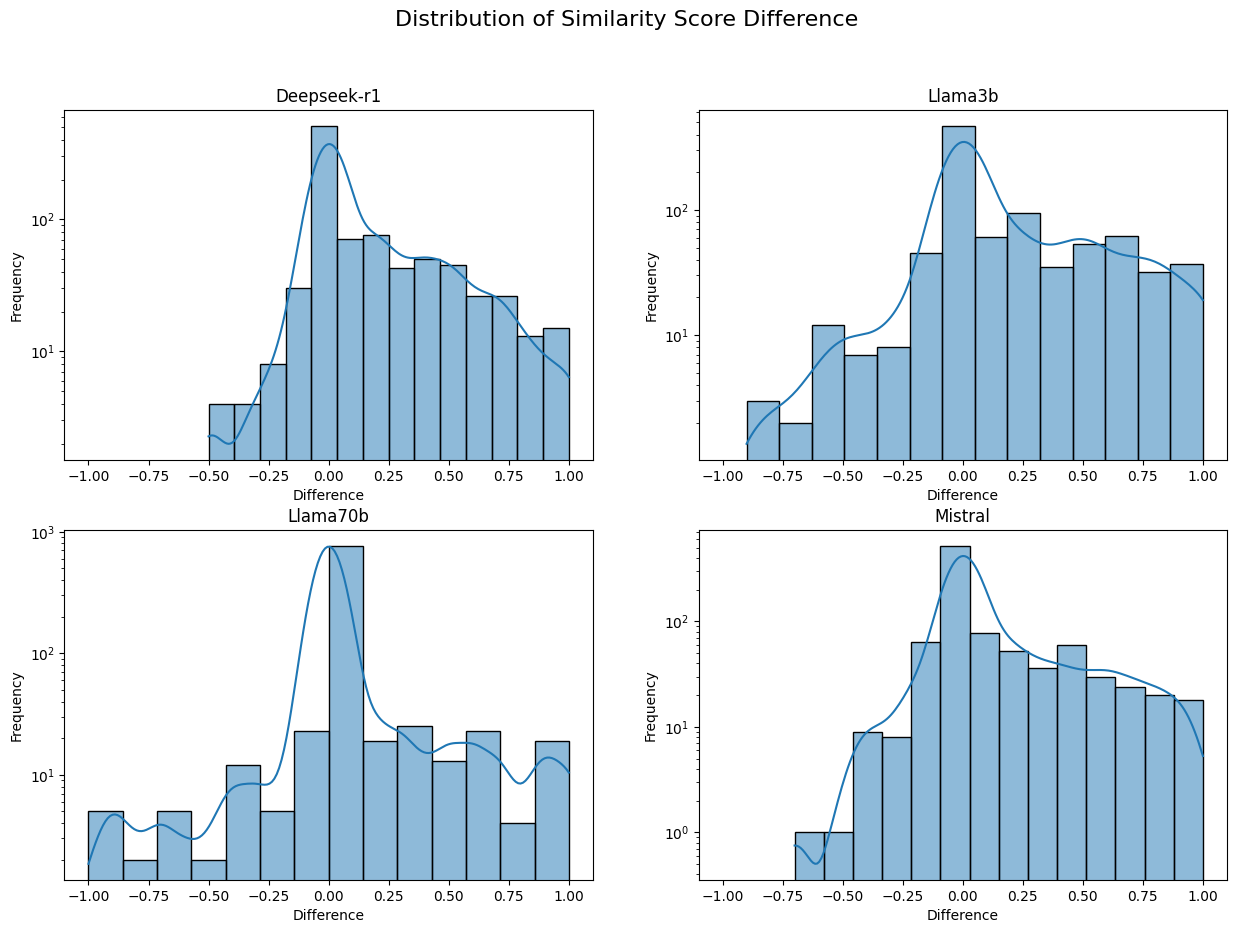

In [26]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(15, 10))
plt.suptitle("Distribution of Similarity Score Difference", fontsize=16)
for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    data_subset = df_pivot[(df_pivot["model"] == model)]
    data_subset = data_subset.groupby('title')['difference'].mean().reset_index()
    sns.histplot(data=data_subset, x="difference", bins=14, kde=True)
    plt.title(f"{model.capitalize()}")
    # plt.ylim(1, max_y)  # Set the same y-axis limit
    plt.xlim(-1.1, 1.1)  # Set the same x-axis limit
    plt.xlabel("Difference")
    plt.yscale('log')
    plt.ylabel("Frequency")

looking at the change in matching rate for eaach jobs, most jobs didnt get a boost (0 match rate). more jobs gets a boost of matching rate, although some jobs perform poorer using persona than benchmark.

In [27]:
#get a df to show the average correct match rate by model and prompt
avg_hits = df_avg.groupby(["model", "prompt"])["correct_match"].mean().reset_index()
avg_hits = avg_hits.pivot(index="model", columns="prompt", values="correct_match").reset_index()
avg_hits.columns.name = None  # Remove the name of the columns
avg_hits = avg_hits.rename(columns={"benchmark": "average_benchmark", "persona": "average_persona"})
avg_hits["difference"] = avg_hits["average_persona"] - avg_hits["average_benchmark"]
avg_hits["percentage_difference"] = (avg_hits["difference"] / avg_hits["average_benchmark"]) * 100
avg_hits = avg_hits.sort_values(by="percentage_difference", ascending=False)
avg_hits

,model,average_benchmark,average_persona,difference,percentage_difference
0,deepseek-r1,0.079198,0.218310,0.139112,175.649795
1,llama3b,0.153738,0.314735,0.160997,104.721635
3,mistral,0.111593,0.227736,0.116143,104.077670
2,llama70b,0.318635,0.362189,0.043554,13.668820


deepseek receives the largest boost. notably after the use of persona, llama 3b perform comparably to 70b model.

## correct match by industry and zone

In [13]:
df_industry = df_pivot[["model", "iteration", "industry", "persona", "benchmark"]]
df_industry = df_industry.groupby(["model", "iteration", "industry"]).mean().reset_index()
df_industry

prompt,model,iteration,industry,persona,benchmark
0,deepseek-r1,0,11,0.392857,0.285714
1,deepseek-r1,0,13,0.354167,0.062500
2,deepseek-r1,0,15,0.361111,0.166667
3,deepseek-r1,0,17,0.142857,0.000000
4,deepseek-r1,0,19,0.216667,0.050000
...,...,...,...,...,...
875,mistral,9,45,0.166667,0.250000
876,mistral,9,47,0.114754,0.098361
877,mistral,9,49,0.140000,0.060000
878,mistral,9,51,0.056075,0.009346


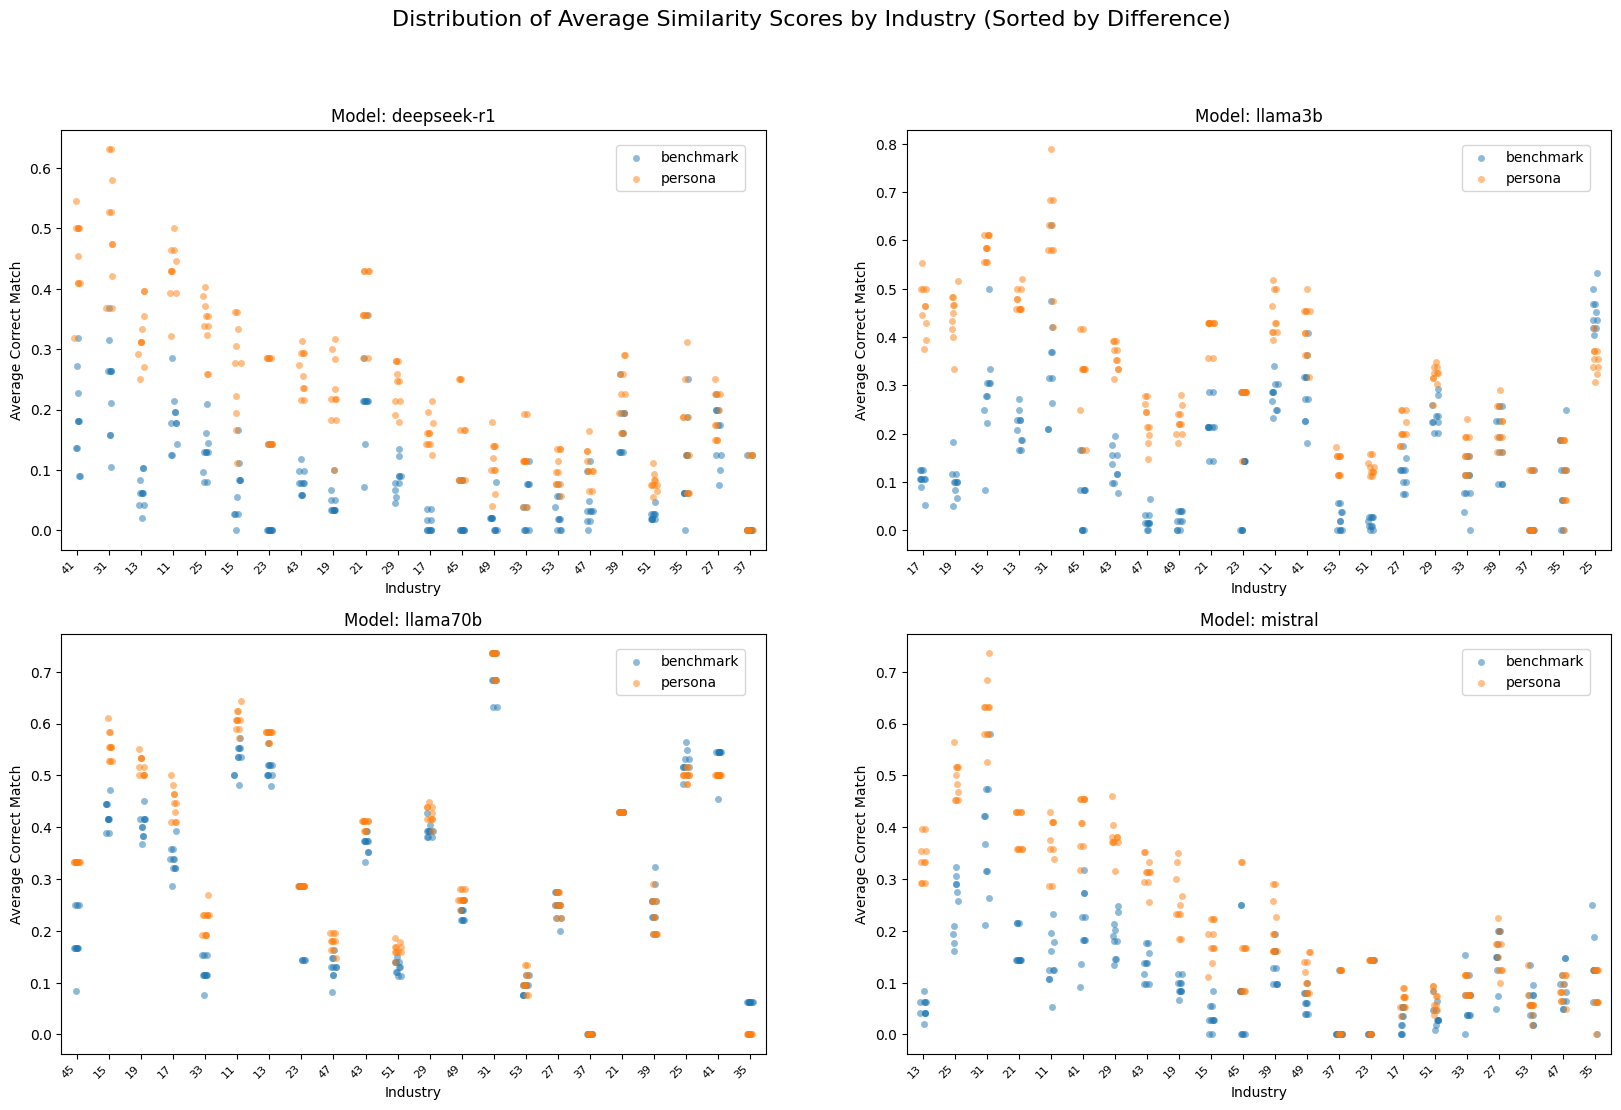

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 12))
plt.suptitle("Distribution of Average Similarity Scores by Industry (Sorted by Difference)", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = df_industry[df_industry['model'] == model].copy()

    # Calculate the difference for sorting industries
    df_diff = df_model.groupby('industry')[['benchmark', 'persona']].mean()
    df_diff['difference'] = df_diff['persona'] - df_diff['benchmark']
    df_diff_sorted = df_diff.sort_values(by='difference', ascending=False).index

    # Use the sorted order for the stripplot
    sns.stripplot(x='industry', y='benchmark', label='benchmark', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted)
    sns.stripplot(x='industry', y='persona', label='persona', data=df_model, dodge=False, alpha=0.5, order=df_diff_sorted)
    

    plt.title(f'Model: {model}')
    plt.xlabel('Industry')
    plt.ylabel('Average Correct Match')
    plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[21:23], labels[21:23], loc='upper right', bbox_to_anchor=(0.98, 0.98))


plt.show()

boost of persona shown in industry. on the right side, it shows that for some industries, persona prompt effect is not obvious, or even detrimental. 

In [31]:
import statsmodels.formula.api as smf
df_regression = df_pivot.groupby(["model", "title", "industry"]).mean().reset_index().drop(columns=["iteration"])
df_regression['industry'] = pd.Categorical(df_regression['industry'])
df_regression['zone'] = pd.Categorical(df_regression['zone'])
df_regression = df_regression.melt(id_vars=['model', 'title', 'industry', 'zone'],
                             value_vars=['benchmark', 'persona'],
                             var_name='prompt',
                             value_name='average_similarity_score')
df_regression = df_regression[df_regression['model'] == "mistral"].copy()
# Model the similarity score ('all_fit') as a function of prompt, industry, job_zone, and their interactions
formula_with_prompt = 'average_similarity_score ~ C(prompt)'# * C(industry)'
model_with_prompt = smf.ols(formula_with_prompt, data=df_regression)
results_with_prompt = model_with_prompt.fit()

print(results_with_prompt.summary())

                               OLS Regression Results                               
Dep. Variable:     average_similarity_score   R-squared:                       0.042
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     80.97
Date:                      Tue, 13 May 2025   Prob (F-statistic):           5.56e-19
Time:                              11:35:23   Log-Likelihood:                -250.45
No. Observations:                      1846   AIC:                             504.9
Df Residuals:                          1844   BIC:                             516.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

above shows prompt has strong effect in increasing matching rate.

In [16]:
model = ["mistral"]
df_ind = df_avg[df_avg["model"] == model[0]].copy()
df_ind = df_ind.pivot_table(index=["industry"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_ind["difference"] = df_ind["persona"] - df_ind["benchmark"]
df_ind = df_ind.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_ind["benchmark"] = df_ind["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_ind["persona"] = df_ind["persona"].apply(lambda x: "{:.2f}%".format(x))
df_ind["difference"] = df_ind["difference"].apply(lambda x: "{:.2f}%".format(x))
df_ind

prompt,industry,benchmark,persona,difference
1,13,5.21%,33.75%,28.54%
7,25,24.84%,49.19%,24.35%
10,31,38.42%,62.11%,23.68%
5,21,16.43%,39.29%,22.86%
0,11,14.11%,36.61%,22.50%
15,41,20.91%,41.36%,20.45%
9,29,18.76%,38.09%,19.33%
16,43,13.33%,31.37%,18.04%
4,19,9.33%,25.67%,16.33%
2,15,3.33%,18.06%,14.72%


In [17]:
df_mistral = df[df["model"] == "mistral"].copy()
df_mistral_reg = df_mistral[["title", "industry", "prompt", "correct_match", "zone"]]
df_mistral_reg

,title,industry,prompt,correct_match,zone
55380,Chief Executives,11,benchmark,0,5
55381,Chief Sustainability Officers,11,benchmark,0,5
55382,General and Operations Managers,11,benchmark,0,4
55383,Legislators,11,benchmark,0,4
55384,Advertising and Promotions Managers,11,benchmark,0,4
...,...,...,...,...,...
73835,Gas Compressor and Gas Pumping Station Operators,53,persona,0,2
73836,"Pump Operators, Except Wellhead Pumpers",53,persona,0,2
73837,Wellhead Pumpers,53,persona,0,2
73838,Refuse and Recyclable Material Collectors,53,persona,0,2


In [18]:
zone_industry_counts = pd.crosstab(df_mistral['industry'], df_mistral['zone']).div(10)
zone_industry_counts = zone_industry_counts.astype(int)
zone_industry_counts["sum"] = zone_industry_counts.sum(axis=1)
zone_industry_counts = zone_industry_counts.sort_values(by="sum", ascending=False)
zone_industry_counts

zone,1,2,3,4,5,sum
industry,,,,,,
51,14,162,38,0,0,214
29,0,0,56,18,104,178
25,0,0,14,26,84,124
47,16,84,22,0,0,122
19,0,0,22,40,58,120
11,0,6,14,78,14,112
17,0,2,28,74,8,112
53,2,78,20,4,0,104
43,0,72,26,4,0,102


not a signle industry contains jobs from all 5 zones. so some industry effect might be misinterpreted. thats why 2 regressions will be run, one with prompt x industry, andother is prompt x zone

for prompt x industry, 47 will be used a baseline because benchmark and persona difference is small, closer to average benchmark matching rate, and more frequent in the dataset.

In [19]:
# Ensure 'prompt' and 'industry' are treated as categorical
df_mistral_reg_industry = df_mistral_reg.copy()
df_mistral_reg_industry['prompt'] = pd.Categorical(df_mistral_reg_industry['prompt'])
df_mistral_reg_industry['industry'] = pd.Categorical(df_mistral_reg_industry['industry'])

# Set 'benchmark' as the reference for 'prompt'
df_mistral_reg_industry['prompt'] = df_mistral_reg_industry['prompt'].cat.reorder_categories(['benchmark'] + [p for p in df_mistral_reg_industry['prompt'].cat.categories if p != 'benchmark'], ordered=False)
df_mistral_reg_industry['prompt'] = df_mistral_reg_industry['prompt'].cat.set_categories(df_mistral_reg_industry['prompt'].cat.categories, ordered=False)

# Set '47' as the reference for 'industry'
reference_industry = '47'
if reference_industry in df_mistral_reg_industry['industry'].cat.categories:
    new_industry_categories = [reference_industry] + [ind for ind in df_mistral_reg_industry['industry'].cat.categories if ind != reference_industry]
    df_mistral_reg_industry['industry'] = df_mistral_reg_industry['industry'].cat.reorder_categories(new_industry_categories, ordered=False)
    df_mistral_reg_industry['industry'] = df_mistral_reg_industry['industry'].cat.set_categories(df_mistral_reg_industry['industry'].cat.categories, ordered=False)
else:
    print(f"Warning: Industry '{reference_industry}' not found in the 'industry' column.")

# Run the logistic regression model with the interaction term
formula = "correct_match ~ C(prompt) + C(industry) + C(prompt):C(industry)"
model_prompt_industry = smf.logit(formula, data=df_mistral_reg_industry).fit()

# Print the model summary
print(model_prompt_industry.summary())

# Optional: Get the odds ratios
odds_ratios_prompt_industry = pd.DataFrame(np.exp(model_prompt_industry.params), columns=['Odds Ratio'])
print("\nOdds Ratios (with 'benchmark' as prompt reference and '47' as industry reference):\n", odds_ratios_prompt_industry)

Optimization terminated successfully.
         Current function value: 0.395618
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          correct_match   No. Observations:                18460
Model:                          Logit   Df Residuals:                    18416
Method:                           MLE   Df Model:                           43
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.1312
Time:                        09:04:06   Log-Likelihood:                -7303.1
converged:                       True   LL-Null:                       -8405.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -2.2918   

C(prompt)[T.persona]                      -0.0605      0.201     -0.301      0.763      -0.454       0.333 \
persona effect in 47 is small and insignificant, which is expected.

In [20]:
model = ["mistral"]
df_zone = df_avg[df_avg["model"] == model[0]].copy()
df_zone = df_zone.pivot_table(index=["zone"], columns=["prompt"], values="correct_match").mul(100).reset_index()
df_zone["difference"] = df_zone["persona"] - df_zone["benchmark"]
df_zone = df_zone.sort_values(by="difference", ascending=False)
# find out average matching rate for each column
df_zone["benchmark"] = df_zone["benchmark"].apply(lambda x: "{:.2f}%".format(x))
df_zone["persona"] = df_zone["persona"].apply(lambda x: "{:.2f}%".format(x))
df_zone["difference"] = df_zone["difference"].apply(lambda x: "{:.2f}%".format(x))
df_zone

prompt,zone,benchmark,persona,difference
4,5,16.56%,37.60%,21.04%
3,4,10.04%,26.52%,16.47%
2,3,10.37%,19.04%,8.68%
1,2,10.17%,16.34%,6.17%
0,1,7.42%,9.68%,2.26%


In [21]:
#find out the count of each zone
zone_counts = df_mistral["zone"].value_counts().div(20)
zone_counts = zone_counts.astype(int).reset_index()
zone_counts

,zone,count
0,2,295
1,4,224
2,3,219
3,5,154
4,1,31


In [22]:
# Ensure 'prompt' and 'zone' are treated as categorical
df_mistral_reg_zone = df_mistral_reg.copy()
df_mistral_reg_zone['prompt'] = pd.Categorical(df_mistral_reg_zone['prompt'])
df_mistral_reg_zone['zone'] = pd.Categorical(df_mistral_reg_zone['zone'])

# Set 'benchmark' as the reference for 'prompt'
df_mistral_reg_zone['prompt'] = df_mistral_reg_zone['prompt'].cat.reorder_categories(['benchmark'] + [p for p in df_mistral_reg_zone['prompt'].cat.categories if p != 'benchmark'], ordered=False)
df_mistral_reg_zone['prompt'] = df_mistral_reg_zone['prompt'].cat.set_categories(df_mistral_reg_zone['prompt'].cat.categories, ordered=False)

# Set '47' as the reference for 'zone'
reference_zone = 2
if reference_zone in df_mistral_reg_zone['zone'].cat.categories:
    new_zone_categories = [reference_zone] + [ind for ind in df_mistral_reg_zone['zone'].cat.categories if ind != reference_zone]
    df_mistral_reg_zone['zone'] = df_mistral_reg_zone['zone'].cat.reorder_categories(new_zone_categories, ordered=False)
    df_mistral_reg_zone['zone'] = df_mistral_reg_zone['zone'].cat.set_categories(df_mistral_reg_zone['zone'].cat.categories, ordered=False)
else:
    print(f"Warning: zone '{reference_zone}' not found in the 'zone' column.")

# Run the logistic regression model with the interaction term
formula = "correct_match ~ C(prompt) + C(zone) + C(prompt):C(zone)"
model_prompt_zone = smf.logit(formula, data=df_mistral_reg_zone).fit()

# Print the model summary
print(model_prompt_zone.summary())

# Optional: Get the odds ratios
odds_ratios_prompt_zone = pd.DataFrame(np.exp(model_prompt_zone.params), columns=['Odds Ratio'])
print("\nOdds Ratios (with 'benchmark' as prompt reference and '47' as zone reference):\n", odds_ratios_prompt_zone)

Optimization terminated successfully.
         Current function value: 0.433161
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          correct_match   No. Observations:                18460
Model:                          Logit   Df Residuals:                    18450
Method:                           MLE   Df Model:                            9
Date:                Tue, 13 May 2025   Pseudo R-squ.:                 0.04874
Time:                        09:04:06   Log-Likelihood:                -7996.2
converged:                       True   LL-Null:                       -8405.8
Covariance Type:            nonrobust   LLR p-value:                1.472e-170
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -2.1785      0.061    -35

C(prompt)[T.persona] shows with persona, it helps increase the log odds by 0.5453 and its significant. \
\
except zone 5, all other zone perform similarly without benchmark. log odds is small and insignificant. \
\
but after persona, zone 4 C(prompt)[T.persona]:C(zone)[T.4] and zone 5 benefit a lot from persona since log odds are high and significant.

In [23]:
model_prompt_zone.pvalues

Intercept                            4.122493e-280
C(prompt)[T.persona]                  4.185897e-12
C(zone)[T.1]                          1.248756e-01
C(zone)[T.3]                          8.189916e-01
C(zone)[T.4]                          8.825489e-01
C(zone)[T.5]                          9.341380e-10
C(prompt)[T.persona]:C(zone)[T.1]     3.956302e-01
C(prompt)[T.persona]:C(zone)[T.3]     1.651400e-01
C(prompt)[T.persona]:C(zone)[T.4]     6.016545e-08
C(prompt)[T.persona]:C(zone)[T.5]     1.319462e-06
dtype: float64

The 'persona' prompt has a statistically significant positive effect on the likelihood of a correct match in the reference zone ('2').\
\
The 'persona' prompt also has a significantly more positive effect in Zone '4' and Zone '5' compared to the reference zone. This suggests that the 'persona' prompt is particularly beneficial in these zones.\
\
The effect of the 'persona' prompt in Zone '1' and Zone '3' is not significantly different from its effect in the reference zone.\
\
The baseline matching rates (with the 'benchmark' prompt) differ across zones, with Zone '5' having a significantly higher rate than the reference zone.\
\
more complex job is benefited by persona prompt more.

### Recall

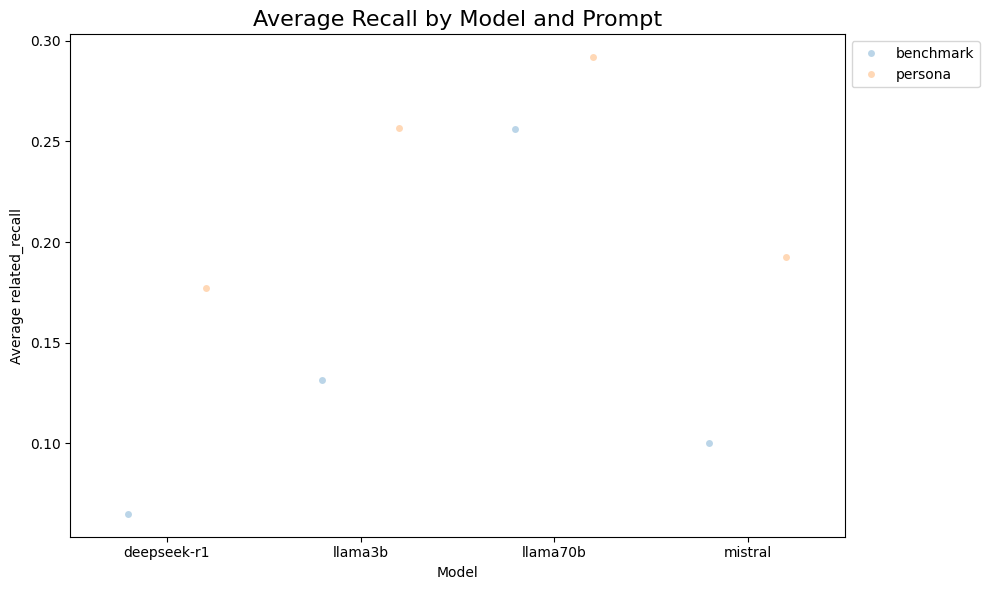

In [24]:
# Calculate the average related_recall for each model and prompt
avg_hits = df.groupby(["model", "prompt"])["related_recall"].mean().reset_index()

# Create a single barplot
plt.figure(figsize=(10, 6))
# sns.violinplot(data=df_avg, x="model", y="related_recall", hue="prompt", bw_adjust=3)
sns.stripplot(data=avg_hits, x="model", y="related_recall", hue="prompt", dodge=True, 
              size=5, alpha=0.3, jitter=True)

# Add labels and title
plt.title("Average Recall by Model and Prompt", fontsize=16)
plt.xlabel("Model")
plt.ylabel("Average related_recall")
 # Ensure some padding on the y-axis, no box around the legend
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()